<a href="https://colab.research.google.com/github/jibbals/supersat/blob/master/Copy_of_lesson7_superres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Super resolution

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Mounted at /content/gdrive


In [2]:
  !curl -s https://course.fast.ai/setup/colab | bash


Updating fastai...
Done.


In [0]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

In [3]:
#path = untar_data(URLs.PETS)
#path_hr = path/'images'
#path_lr = path/'small-96'
#path_mr = path/'small-256'


path = base_dir + 'All Images'

path_hr = Path(path + '/SH')
path_mr = Path(path + '/SM')
path_lr = Path(path + '/SL')

print(os.path.isdir(path_lr))
print(path_lr)
print(str(path_lr))
import glob
print(glob.glob(str(path_lr)+'/*'))
print(glob.glob('/content/gdrive/My Drive/fastai-v3/All Images/SL/*'))

True
/content/gdrive/My Drive/fastai-v3/All Images/SL
/content/gdrive/My Drive/fastai-v3/All Images/SL
['/content/gdrive/My Drive/fastai-v3/All Images/SL/1780.png', '/content/gdrive/My Drive/fastai-v3/All Images/SL/4834.png', '/content/gdrive/My Drive/fastai-v3/All Images/SL/1970.png', '/content/gdrive/My Drive/fastai-v3/All Images/SL/4363.png', '/content/gdrive/My Drive/fastai-v3/All Images/SL/3342.png', '/content/gdrive/My Drive/fastai-v3/All Images/SL/3424.png', '/content/gdrive/My Drive/fastai-v3/All Images/SL/6560.png', '/content/gdrive/My Drive/fastai-v3/All Images/SL/3356.png', '/content/gdrive/My Drive/fastai-v3/All Images/SL/3418.png', '/content/gdrive/My Drive/fastai-v3/All Images/SL/2712.png', '/content/gdrive/My Drive/fastai-v3/All Images/SL/5082.png', '/content/gdrive/My Drive/fastai-v3/All Images/SL/1637.png', '/content/gdrive/My Drive/fastai-v3/All Images/SL/1145.png', '/content/gdrive/My Drive/fastai-v3/All Images/SL/5451.png', '/content/gdrive/My Drive/fastai-v3/All Im

In [4]:
free = gpu_mem_get_free_no_cache()
free


16270

In [0]:
il = ImageList.from_folder(path_hr)

In [0]:
def resize_one(fn, i, path, size):
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [0]:
# create smaller image sets the first time this nb is run
sets = [(path_lr, 96), (path_mr, 256)]
for p,size in sets:
    if not p.exists(): 
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size), il.items)

In [0]:
bs,size=64,128 #32,128
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [0]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [10]:
data = get_data(bs,size)
data

ImageDataBunch;

Train: LabelList (737 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /content/gdrive/My Drive/fastai-v3/All Images/SL;

Valid: LabelList (81 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /content/gdrive/My Drive/fastai-v3/All Images/SL;

Test: None

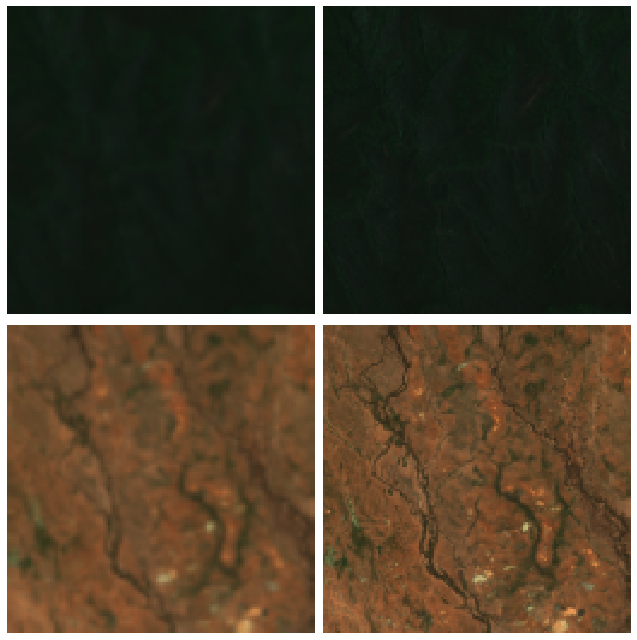

In [11]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

## Feature loss

In [0]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [0]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [14]:
gram_matrix(t)

tensor([[[0.0013, 0.0020, 0.0014],
         [0.0020, 0.0032, 0.0022],
         [0.0014, 0.0022, 0.0015]],

        [[0.0013, 0.0020, 0.0014],
         [0.0020, 0.0032, 0.0022],
         [0.0014, 0.0022, 0.0015]]])

In [0]:
base_loss = F.l1_loss

In [16]:
copy_to = '/root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth'
copy_from = base_dir + 'vgg16_bn-6c64b313.pth'
print(copy_from)
shutil.copyfile(copy_from, copy_to) 

/content/gdrive/My Drive/fastai-v3/vgg16_bn-6c64b313.pth


'/root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth'

In [0]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [18]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [0]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

In [21]:
copy_to = '/root/.cache/torch/checkpoints/resnet34-333f7ec4.pth'
copy_from = base_dir + 'resnet34-333f7ec4.pth'
print(copy_from)
shutil.copyfile(copy_from, copy_to) 

/content/gdrive/My Drive/fastai-v3/resnet34-333f7ec4.pth


'/root/.cache/torch/checkpoints/resnet34-333f7ec4.pth'

## Train

In [0]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


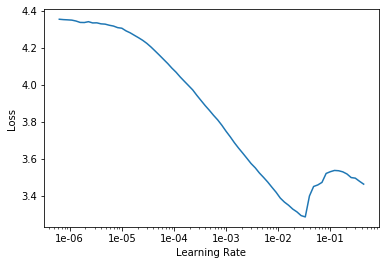

In [24]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-3

In [0]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start,callbacks=[ShowGraph(learn), SaveModelCallback(learn,monitor='valid_loss', mode='min',name=save_name)]) #was 10
    #learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)





epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,3.828523,3.497750,0.302106,0.315259,0.343680,0.094412,1.188581,1.178018,0.075694,00:21
1,3.290402,2.574885,0.160913,0.264223,0.319492,0.072768,0.745341,0.961131,0.051017,00:16
2,2.834887,1.818107,0.107792,0.215709,0.259586,0.050018,0.465641,0.685196,0.034164,00:16
3,2.485724,1.647662,0.089986,0.191518,0.235037,0.047611,0.419916,0.630739,0.032854,00:16
4,2.242351,1.596259,0.120001,0.179968,0.219740,0.046197,0.404651,0.592808,0.032894,00:16
5,2.086963,1.546873,0.109272,0.175820,0.214927,0.043790,0.397924,0.574358,0.030782,00:16
6,1.966497,1.556427,0.101775,0.173020,0.214045,0.045003,0.403612,0.587357,0.031615,00:15
7,1.912571,1.545479,0.130774,0.174258,0.211674,0.043603,0.391898,0.562277,0.030995,00:15
8,1.824900,1.382238,0.124493,0.164205,0.201433,0.041081,0.320625,0.500964,0.029438,00:15
9,1.735056,1.272578,0.076399,0.158291,0.191420,0.039551,0.306912,0.471242,0.028763,00:15


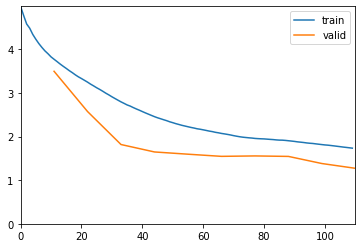

Better model found at epoch 0 with valid_loss value: 3.4977495670318604.
Better model found at epoch 1 with valid_loss value: 2.574885129928589.
Better model found at epoch 2 with valid_loss value: 1.8181065320968628.
Better model found at epoch 3 with valid_loss value: 1.647661566734314.
Better model found at epoch 4 with valid_loss value: 1.5962588787078857.
Better model found at epoch 5 with valid_loss value: 1.546872854232788.
Better model found at epoch 7 with valid_loss value: 1.5454787015914917.
Better model found at epoch 8 with valid_loss value: 1.3822382688522339.
Better model found at epoch 9 with valid_loss value: 1.2725778818130493.


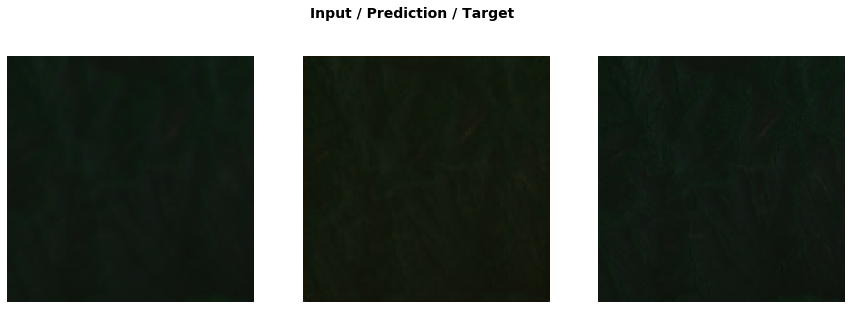

In [25]:
do_fit('1a', slice(lr*10))

In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.338606,1.250403,0.068184,0.157316,0.189891,0.038948,0.300349,0.467466,0.028249,00:15
1,1.329831,1.233639,0.069262,0.156758,0.189010,0.038539,0.292131,0.459993,0.027945,00:16
2,1.322703,1.221446,0.070117,0.155871,0.188486,0.038396,0.284766,0.455979,0.027831,00:15
3,1.314507,1.227982,0.067765,0.155924,0.188256,0.038409,0.289752,0.460118,0.027758,00:16
4,1.305623,1.193559,0.067220,0.153732,0.185901,0.037828,0.272345,0.449023,0.027509,00:15
5,1.296264,1.188984,0.071878,0.152187,0.182959,0.037537,0.272703,0.444452,0.027267,00:15
6,1.285279,1.152268,0.065819,0.150066,0.181043,0.037024,0.256965,0.434439,0.026912,00:16
7,1.272968,1.145116,0.068397,0.148856,0.179446,0.036700,0.254010,0.431090,0.026617,00:16
8,1.263576,1.141173,0.068065,0.148073,0.178476,0.036474,0.252646,0.430870,0.026569,00:16
9,1.254942,1.129659,0.065596,0.146816,0.177204,0.036045,0.251350,0.426537,0.026111,00:16


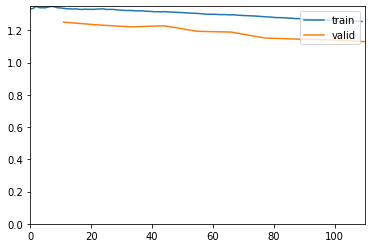

Better model found at epoch 0 with valid_loss value: 1.2504029273986816.
Better model found at epoch 1 with valid_loss value: 1.2336386442184448.
Better model found at epoch 2 with valid_loss value: 1.2214456796646118.
Better model found at epoch 4 with valid_loss value: 1.1935588121414185.
Better model found at epoch 5 with valid_loss value: 1.1889840364456177.
Better model found at epoch 6 with valid_loss value: 1.1522678136825562.
Better model found at epoch 7 with valid_loss value: 1.1451162099838257.
Better model found at epoch 8 with valid_loss value: 1.141173243522644.
Better model found at epoch 9 with valid_loss value: 1.1296594142913818.


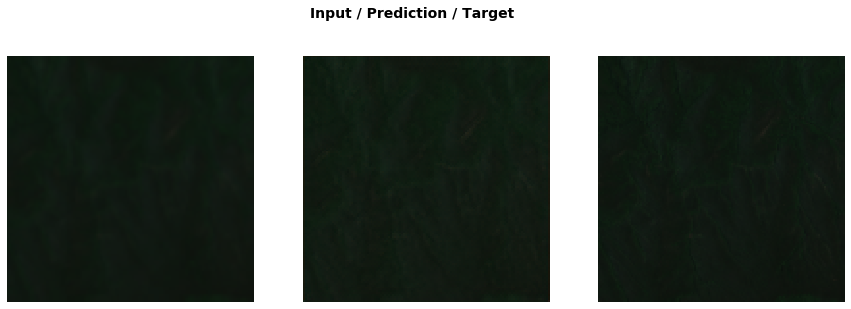

In [27]:
#do_fit('1b', slice(1e-5,lr))
do_fit('1b', slice(1e-5,lr,))
#learn_gen.fit_one_cycle(100, pct_start=0.8, callbacks=[ShowGraph(learn_gen),
#SaveModelCallback(learn_gen,monitor='valid_loss', mode='min',name="RN34")])

In [0]:
data = get_data(12,size*2)

In [29]:
learn.data = data
learn.freeze()
gc.collect()

4651

In [0]:
learn.load('1b');

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.302096,1.169012,0.073691,0.195675,0.202885,0.040798,0.317397,0.316378,0.022188,00:46
1,1.236151,1.162817,0.075868,0.199044,0.206208,0.041013,0.305532,0.312967,0.022185,00:31
2,1.179469,1.116999,0.076719,0.199345,0.204277,0.040567,0.280985,0.293227,0.021879,00:31
3,1.142932,1.120350,0.078350,0.204220,0.205197,0.040713,0.275777,0.294360,0.021734,00:31
4,1.130669,1.137702,0.082617,0.204630,0.207924,0.040026,0.287255,0.293666,0.021583,00:31
5,1.119420,1.091556,0.077948,0.197350,0.200316,0.040071,0.270880,0.283519,0.021473,00:31
6,1.124339,1.122838,0.080645,0.201993,0.205453,0.039819,0.282885,0.290570,0.021473,00:31
7,1.106834,1.094671,0.086983,0.199370,0.202235,0.040492,0.262782,0.281311,0.021497,00:31
8,1.096104,1.085516,0.080520,0.200810,0.204459,0.039513,0.263496,0.275578,0.021139,00:30
9,1.085938,1.049131,0.077131,0.198169,0.201192,0.039888,0.240755,0.270522,0.021473,00:31


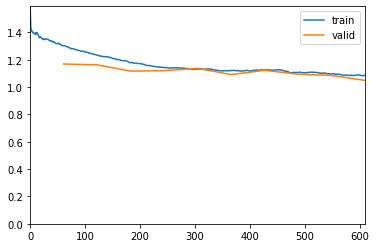

Better model found at epoch 0 with valid_loss value: 1.169012427330017.
Better model found at epoch 1 with valid_loss value: 1.162817358970642.
Better model found at epoch 2 with valid_loss value: 1.1169989109039307.
Better model found at epoch 5 with valid_loss value: 1.0915560722351074.
Better model found at epoch 8 with valid_loss value: 1.0855158567428589.
Better model found at epoch 9 with valid_loss value: 1.049130916595459.


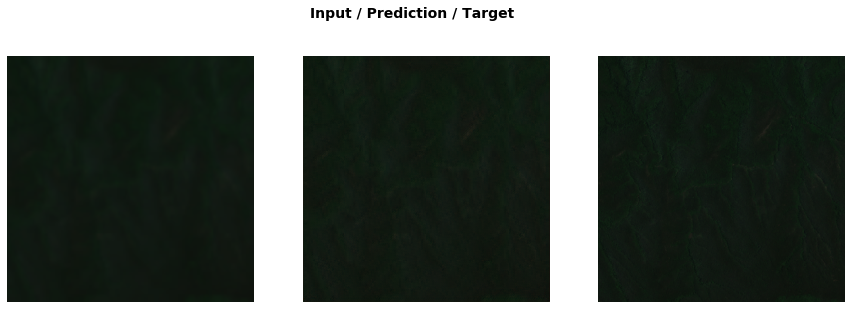

In [31]:
do_fit('2a')

In [0]:
 learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.056230,1.045316,0.076791,0.198318,0.201566,0.039908,0.238070,0.269230,0.021434,00:32
1,1.056390,1.040285,0.076978,0.198512,0.201386,0.039999,0.234267,0.267757,0.021385,00:32
2,1.053616,1.040784,0.077454,0.198115,0.201462,0.039830,0.235048,0.267599,0.021274,00:32
3,1.056204,1.037167,0.077572,0.198602,0.201421,0.039946,0.232310,0.266011,0.021305,00:31


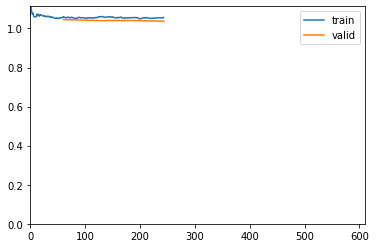

Better model found at epoch 0 with valid_loss value: 1.045316457748413.
Better model found at epoch 1 with valid_loss value: 1.0402852296829224.
Better model found at epoch 3 with valid_loss value: 1.0371670722961426.


KeyboardInterrupt: ignored

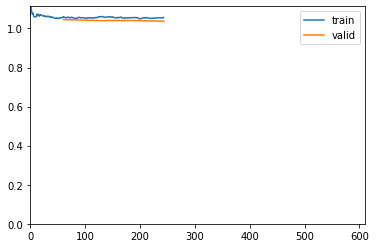

In [33]:
do_fit('2b', slice(1e-6,1e-4), pct_start=0.3)

In [0]:
#learn.save('2b');

## Test

In [0]:
learn = None
gc.collect();

In [35]:
256/320*1024

819.2

In [36]:
256/320*1600

1280.0

In [37]:
free = gpu_mem_get_free_no_cache()
# the max size of the test image depends on the available GPU RAM 
if free > 8000: size=(400, 400) # >  8GB RAM
else:           size=( 400, 400) # <= 8GB RAM
print(f"using size={size}, have {free}MB of GPU RAM free")

using size=(400, 400), have 11035MB of GPU RAM free


In [0]:
learn = unet_learner(data, arch, loss_func=F.l1_loss, blur=True, norm_type=NormType.Weight)

In [0]:
data_mr = (ImageImageList.from_folder(path_mr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.name)
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_mr.c = 3

In [47]:
learn.load('2b');


SyntaxError: ignored

In [0]:
learn.data = data_mr

In [42]:
fn = data_mr.valid_ds.x.items[0]; fn


PosixPath('/content/gdrive/My Drive/fastai-v3/All Images/SM/1231.png')

In [43]:
img = open_image(fn); img.shape

torch.Size([3, 160, 160])

In [0]:
p,img_hr,b = learn.predict(img)

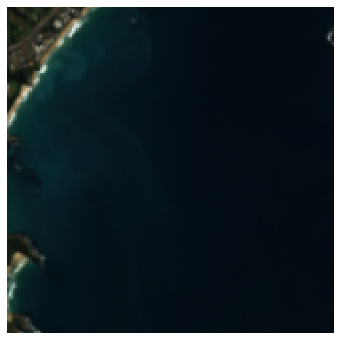

In [45]:
show_image(img, figsize=(6,6), interpolation='nearest');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


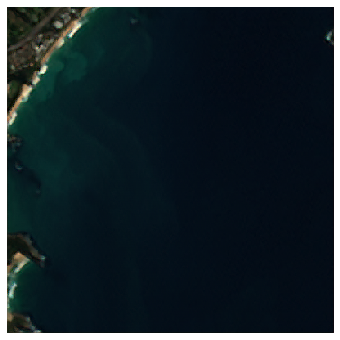

In [46]:
Image(img_hr).show(figsize=(6,6))